# MONAI Airway Segmentation

In [74]:
import os
from glob import glob
import torch
from monai.transforms import (
    Compose,
    LoadImaged,
    ToTensord,
    AddChanneld,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
)
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader
from monai.utils import first
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
import matplotlib.pyplot as plt

In [10]:
data_dir = "/home/jtabalon/rabbit_seg/sample_seg"

In [11]:
train_images = glob(os.path.join(data_dir, 'train_data', 'ct.nii'))
train_labels = glob(os.path.join(data_dir, "labels", "airway.nii"))
print(train_images, train_labels)

['/home/jtabalon/rabbit_seg/sample_seg/train_data/ct.nii'] ['/home/jtabalon/rabbit_seg/sample_seg/labels/airway.nii']


In [12]:
train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

In [13]:
print(train_files)

[{'image': '/home/jtabalon/rabbit_seg/sample_seg/train_data/ct.nii', 'label': '/home/jtabalon/rabbit_seg/sample_seg/labels/airway.nii'}]


In [14]:
# load the images
# do any transforms
# need to convert into torch tensors

In [46]:
# load the images

train_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        #Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2)),
        Spacingd(keys=['image', 'label'], pixdim=(1.0, 1.0, 1.0)),
        #ScaleIntensityRanged(keys='image', a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        #Resized(keys=['image', 'label'], spatial_size=[662, 512, 512]),
        ToTensord(keys=['image', 'label']),
    ]
)


In [47]:
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1)

## Visualize First Patient

In [48]:
test_patient = first(train_loader)
print(test_patient)

{'image': tensor([[[[[ -983.,  -981., -1016.,  ...,  -981., -1014.,  -989.],
           [-1013.,  -999., -1010.,  ...,  -968., -1000.,  -993.],
           [-1024., -1024.,  -991.,  ...,  -974.,  -969., -1022.],
           ...,
           [ -984.,  -942.,  -967.,  ...,  -996.,  -956.,  -985.],
           [-1023., -1024.,  -999.,  ..., -1013., -1007.,  -995.],
           [-1024., -1024., -1024.,  ..., -1003., -1023., -1010.]],

          [[ -990.,  -999.,  -952.,  ..., -1002., -1015., -1002.],
           [ -950.,  -958.,  -994.,  ..., -1016., -1016.,  -985.],
           [-1016., -1004., -1023.,  ...,  -982., -1003., -1024.],
           ...,
           [-1019., -1024.,  -986.,  ..., -1015.,  -979.,  -997.],
           [-1024., -1024., -1024.,  ..., -1015., -1023., -1003.],
           [-1002.,  -996., -1014.,  ..., -1007., -1024., -1018.]],

          [[-1021., -1015.,  -989.,  ...,  -969., -1009.,  -992.],
           [ -994.,  -997.,  -928.,  ..., -1016., -1019., -1010.],
           [ -98

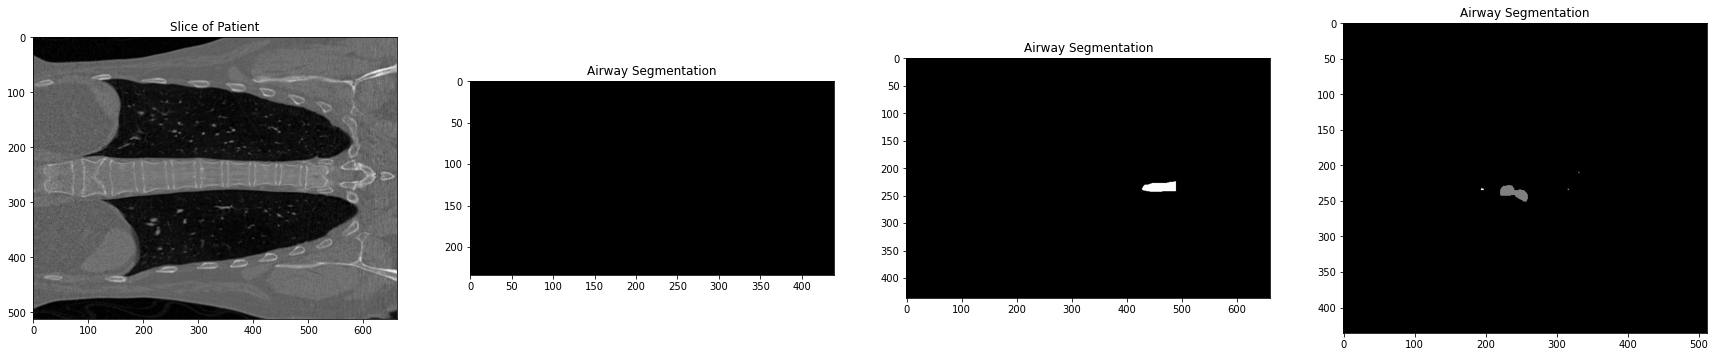

In [68]:
plt.figure('test', (30, 10))


plt.subplot(1, 4, 1)
plt.title('Slice of Patient')
#plt.imshow(test_patient['image'][0, 0, :, :, 30], cmap="gray")
#plt.imshow(test_patient['image'][0, 0, :, 30, :], cmap="gray")
plt.imshow(test_patient['image'][0, 0, 316, :, :], cmap="gray")

plt.subplot(1, 4, 2)
plt.title('Airway Segmentation')
plt.imshow(test_patient['label'][0, 0, 316, :234, :439], cmap="gray")

plt.subplot(1, 4, 3)
plt.title('Airway Segmentation')
plt.imshow(test_patient['label'][0, 0, :, 234, :], cmap="gray")

plt.subplot(1, 4, 4)
plt.title('Airway Segmentation')
plt.imshow(test_patient['label'][0, 0, :, :, 444], cmap="gray")
plt.show()

In [50]:
# Find where - in a given slice - the number of 1s is the highest in order to find the mask of the lungs

In [72]:
import monai

device = torch.device("cuda:0")


net = monai.networks.nets.UNet(
    dimensions=3,
    in_channels=1,
    out_channels=1,
    channels=[8, 16, 32],
    strides=[2, 2]
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

